## Variational autoencoder (VAE)

In [40]:
import keras
from keras import layers
from keras import objectives

In [48]:
# mapping inputs to our latent distribution parameters:
original_dim = 28 * 28
intermediate_dim = 64
latent_dim = 2
batch_size = 32

inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)

In [29]:
# use these parameters to sample new similar points from the latent space:
from keras import backend as K

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

In [30]:
# map these sampled latent points back to reconstructed inputs:
# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')


In [43]:
# Compute VAE loss
def my_vae_loss(y_true, y_pred):
    xent_loss = original_dim * objectives.binary_crossentropy(K.flatten(y_true), K.flatten(y_pred))
    kl_loss = - 0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    vae_loss = K.mean(xent_loss + kl_loss)
    return vae_loss



In [44]:
# train the model using the end-to-end model, with a custom loss function: the sum of a reconstruction term, and the KL # divergence regularization term.
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
#vae_loss = K.mean(reconstruction_loss + kl_loss)
#vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop', loss=my_vae_loss)

In [63]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))


<class 'numpy.ndarray'>


In [73]:
vae.fit(x_train, x_train,
        shuffle=True,
        nb_epoch=100,
        verbose=2,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
 - 6s - loss: 295.8079 - val_loss: 297.2855
Epoch 2/100
 - 5s - loss: 295.7010 - val_loss: 297.7212
Epoch 3/100
 - 5s - loss: 295.5947 - val_loss: 297.5479
Epoch 4/100
 - 5s - loss: 295.5031 - val_loss: 297.3885
Epoch 5/100
 - 5s - loss: 295.4230 - val_loss: 296.9842
Epoch 6/100
 - 5s - loss: 295.3140 - val_loss: 297.2775
Epoch 7/100
 - 5s - loss: 295.2028 - val_loss: 297.7845
Epoch 8/100
 - 5s - loss: 295.1338 - val_loss: 297.7096
Epoch 9/100
 - 5s - loss: 295.0348 - val_loss: 297.0984
Epoch 10/100
 - 5s - loss: 294.9642 - val_loss: 296.8917
Epoch 11/100
 - 5s - loss: 294.8949 - val_loss: 296.5725
Epoch 12/100
 - 5s - loss: 294.7605 - val_loss: 296.7543
Epoch 13/100
 - 5s - loss: 294.6562 - val_loss: 296.9484
Epoch 14/100
 - 5s - loss: 294.6274 - val_loss: 297.1694
Epoch 15/100
 - 5s - loss: 294.4913 - val_loss: 297.4569
Epoch 16/100
 - 5s - loss: 294.4646 - val_loss: 296.7692
Epoch 17/100
 - 5s - loss: 294.3371 - val_loss:

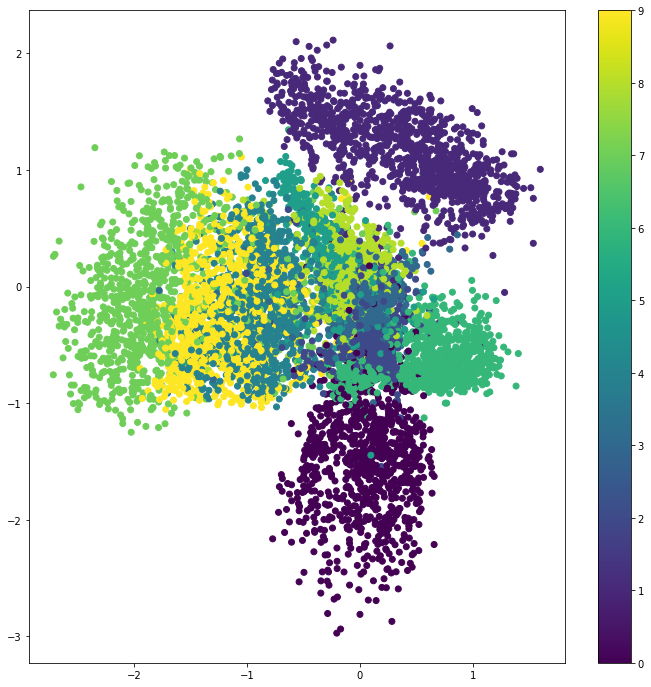

In [74]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)

x_test_encoded = np.array(x_test_encoded)

plt.figure(figsize=(12, 12))
plt.scatter(x_test_encoded[2,:, 0], x_test_encoded[2,:, 1], c=y_test)
plt.colorbar()
plt.show()


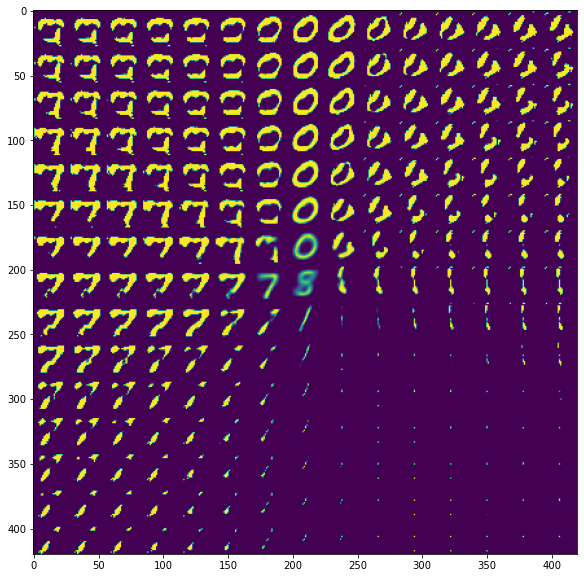

In [76]:
# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()